<a href="https://colab.research.google.com/github/sajtarius/practice/blob/main/nonlinear_all_tidyup.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
import numpy as np 
import matplotlib.pyplot as plt 
import plotly.graph_objects as go 
from plotly.subplots import make_subplots
from matplotlib.animation import FuncAnimation 
from tqdm import tqdm 
from scipy.fft import fft, ifft, fftfreq, fftshift 
from scipy import signal
from scipy.integrate import trapezoid, cumtrapz, solve_ivp
from KDEpy import FFTKDE
#%matplotlib notebook

In [6]:
###functions for all calculation###
###spectrum of two signals###
def spec(s1, s2, time):
    fs1 = fft(s1) #fourier transform signal 1
    fs2 = fft(s2) #fourier transform signal 2
    freq_fs = fftfreq(len(time), d=(time[1] - time[0])) #frequency of the signals
    fs2_con = np.conj(fs2) #conjugate the signal 2
    spectrum = np.mean(fs1*fs2_con, axis=0)/len(time) #element of the spectrum --> [auto] when [s1 = s2]; [cross] when [s1 != s2]
    return spectrum, freq_fs

###[wilson algorithm] is used for factorizing the [spectral matrix] to [transfer matrix] and [covariance matrix of noise]###
#plus operator
def plus(g):
    m = g.shape[0]
    nw = g.shape[2]
    beta = np.zeros((m,m,nw))*(1+1j)
    for i in range(0, m, 1):
        for j in range(0, m, 1):
            beta[i,j,:] = ifft(g[i,j,:])
    betap = beta.copy()
    beta0 = 0.5*beta[:,:,0]
    betap[:,:,0] = np.triu(beta0) 
    betap[:,:,int(nw/2):] = 0 
    gp = np.zeros((m,m,nw))*(1+1j) 
    for i in range(0, m, 1):
        for j in range(0, m, 1):
            gp[i,j,:] = fft(betap[i,j,:]) 
    return gp 

#wilson algorithm
def wilson(s, freq, ite, tol): #spectrum, frequency, iteration_number, accepted error
    m = s.shape[0] 
    nw = s.shape[2] 
    R = np.zeros((m,m,nw))*(1+1j) 
    for i in range(0, m, 1):
        for j in range(0, m, 1):
            R[i,j,:] = ifft(s[i,j,:])
    psi = np.zeros((m,m,nw))*(1+1j)
    for i in range(0, nw, 1):
        psi[:,:,i] = np.linalg.cholesky(R[:,:,0])
    g = np.zeros((m,m,nw))*(1+1j)
    I = np.eye(m,m)
    for t in range(0, ite, 1):
        for i in range(0, nw, 1):
            g[:,:,i] = np.linalg.inv(psi[:,:,i]) @ s[:,:,i] @ np.conj(np.linalg.inv(psi[:,:,i]).T)
            g[:,:,i] = g[:,:,i] + I 
        gp = plus(g)
        psi_old = psi.copy()
        psi_err = 0 
        for i in range(0, nw, 1):
            psi[:,:,i] = psi[:,:,i] @ gp[:,:,i]
            psi_err = psi_err + np.linalg.norm(psi[:,:,i] - psi_old[:,:,i])/nw
        if psi_err < tol: 
            break 
    A = np.zeros((m,m,nw))*(1+1j)
    for i in range(0, m, 1):
        for j in range(0, m, 1):
            A[i,j,:] = ifft(psi[i,j,:])
    A0 = A[:,:,0]
    cov = A0 @ A0.T
    H = np.zeros((m,m,nw))*(1+1j)
    for i in range(0, nw, 1):
        H[:,:,i] = psi[:,:,i] @ np.linalg.inv(A0)
    freq_new = freq[int(len(freq)/2):] #included so that the frequency information is retained. 
    return H, cov, freq

##############################################################
###[transfer entropy] for one signal###
def cal_transfer(source, target, size, alpha):
    new_target = target[alpha+1:]
    old_target = target[:-1-alpha]
    old_source = source[:-1-alpha]
    
    pdf_all, edges_all = np.histogramdd(np.array([new_target, old_target, old_source]).T, density=True, bins=(size, size, size))
    pdf_mar, _ = np.histogramdd(np.array(old_target), density=True, bins=size)
    pdf_joint_old, _ = np.histogramdd(np.array([old_target, old_source]).T, density=True, bins=(size, size))
    pdf_joint_new, _ = np.histogramdd(np.array([new_target, old_target]).T, density=True, bins=(size, size))
    
    dt_new = edges_all[0][1] - edges_all[0][0]
    dt_old = edges_all[1][1] - edges_all[1][0]
    ds_old = edges_all[2][1] - edges_all[2][0]
    
    #using [np.einsum] to make sure the matrix multiply to the correct components. 
    nume = np.einsum('ijk, j -> ijk', pdf_all, pdf_mar)
    deno = np.einsum('jk, ij -> ijk', pdf_joint_old, pdf_joint_new)
    div = np.einsum('ijk, ijk -> ijk', nume, 1/deno)
    
    temp_log = np.log2(div)
    log = np.nan_to_num(temp_log, nan=0.0, posinf=0.0, neginf=0.0)
    
    temp_sol = np.einsum('ijk, ijk', pdf_all, log)
    sol = temp_sol * dt_new * dt_old * ds_old
        
    return sol 

###[transfer entropy] for all the simulation###
def all_cal_transfer(source, target, size, alpha, sim):
    new_target = target[:,alpha+1:].reshape((target[0,alpha+1:].shape[0]*sim))
    old_target = target[:,:-1-alpha].reshape((target[0,:-1-alpha].shape[0]*sim))
    old_source = source[:,:-1-alpha].reshape((source[0,:-1-alpha].shape[0]*sim))
    
    pdf_all, edges_all = np.histogramdd(np.array([new_target, old_target, old_source]).T, density=True, bins=(size, size, size), 
                                        range=[[np.min(target), np.max(target)], [np.min(target), np.max(target)], [np.min(source), np.max(source)]])
    pdf_mar, _ = np.histogramdd(np.array(old_target), density=True, bins=size, range=[[np.min(target), np.max(target)]])
    pdf_joint_old, _ = np.histogramdd(np.array([old_target, old_source]).T, density=True, bins=(size, size), range=[[np.min(target), np.max(target)], [np.min(source), np.max(source)]])
    pdf_joint_new, _ = np.histogramdd(np.array([new_target, old_target]).T, density=True, bins=(size, size), range=[[np.min(target), np.max(target)], [np.min(target), np.max(target)]])
    
    dt_new = edges_all[0][1] - edges_all[0][0]
    dt_old = edges_all[1][1] - edges_all[1][0]
    ds_old = edges_all[2][1] - edges_all[2][0]
    
    #using [np.einsum] to make sure the matrix multiply to the correct components. 
    nume = np.einsum('ijk, j -> ijk', pdf_all, pdf_mar)
    deno = np.einsum('jk, ij -> ijk', pdf_joint_old, pdf_joint_new)
    div = np.einsum('ijk, ijk -> ijk', nume, 1/deno)
    
    temp_log = np.log2(div)
    log = np.nan_to_num(temp_log, nan=0.0, posinf=0.0, neginf=0.0)
    
    temp_sol = np.einsum('ijk, ijk', pdf_all, log)
    sol = temp_sol * dt_new * dt_old * ds_old
        
    return sol 

##############################################################
###evolution of [pdf] with the estimation of [pdf] via [histogram]###
def pdf_evol(signal1, signal2, time, window, slide, sim):
    pdfx1 = []
    axsx1 = []
    
    pdfx2 = []
    axsx2 = []
    
    pdfjoint = []
    axsjoint = []
    
    pdfmul = []
    axsmul = []
    
    newt = []
    
    win = window 
    sld = slide 
    
    size = int(np.ceil(2*(sim*win)**(1/3)))
    
    for t in tqdm(range(0, len(time)-win+1, sld)):
        Hx1, edgesx1 = np.histogramdd(signal1[:, t:t+win].reshape(win*sim).T, density=True, bins=size, range=[[np.min(signal1), np.max(signal1)]])
        Hx2, edgesx2 = np.histogramdd(signal2[:, t:t+win].reshape(win*sim).T, density=True, bins=size, range=[[np.min(signal2), np.max(signal2)]])
        Hx1x2, edgesx1x2 = np.histogramdd(np.array([signal1[:, t:t+win].reshape(win*sim), signal2[:, t:t+win].reshape(win*sim)]).T, density=True, bins=size, range=[[np.min(signal1), np.max(signal1)], [np.min(signal2), np.max(signal2)]])
        
        mulHx1x2 = np.einsum('i,j->ij', Hx1, Hx2)
        
        pdfx1.append(Hx1)
        axsx1.append(edgesx1)
        
        pdfx2.append(Hx2)
        axsx2.append(edgesx2)
        
        pdfjoint.append(Hx1x2)
        axsjoint.append(edgesx1x2)
        
        pdfmul.append(mulHx1x2)
        axsmul.append(edgesx1x2)
        
        newt.append(time[t])
        
    pdfx1 = np.array(pdfx1)
    axsx1 = np.array(axsx1)
    
    pdfx2 = np.array(pdfx2)
    axsx2 = np.array(axsx2)
    
    pdfjoint = np.array(pdfjoint)
    axsjoint = np.array(axsjoint)
    
    pdfmul = np.array(pdfmul)
    axsmul = np.array(axsmul)
    
    newt = np.array(newt)
    
    data = {'pdf_joint': [pdfjoint, axsjoint], 'pdf_mul': [pdfmul, axsmul], 'pdf_1': [pdfx1, axsx1], 'pdf_2': [pdfx2, axsx2]}
    
    return data, newt

###evolution of [conditional pdf] with estimation of [pdf] via [histogram]###
def pdf_evol_condi(signal1, signal2, time, window, slide, sim):
    win = window
    sld = slide 
    
    size = int(np.ceil(2*(sim*win)**(1/3)))
    size = int(np.sqrt(size))
    
    pdfcond1 = []
    axscond1 = []
    
    pdfcond2 = []
    axscond2 = []
    
    newt = []
    
    for t in tqdm(range(0, len(time)-win+1, sld)):
        Hjoint, edgesjoint = np.histogramdd(np.array([signal1[:, t:t+win].reshape(win*sim), signal2[:, t:t+win].reshape(win*sim)]).T, density=True, bins=size, range=[[np.min(signal1), np.max(signal1)], [np.min(signal2), np.max(signal2)]])
        Hx1, edgesx1 = np.histogramdd(signal1[:, t:t+win].reshape(win*sim), density=True, bins=size, range=[[np.min(signal1), np.max(signal1)]])
        Hx2, edgesx2 = np.histogramdd(signal2[:, t:t+win].reshape(win*sim), density=True, bins=size, range=[[np.min(signal2), np.max(signal2)]])
        
        Hcondi1 = np.einsum('ij, i->ij', Hjoint, 1/Hx1) #conditional pdf p(x2|x1) = p(x1,x2)/p(x1)
        Hcondi1 = np.nan_to_num(Hcondi1, nan=0.0, neginf=0.0, posinf=0.0) 
        
        Hcondi2 = np.einsum('ij, j->ij', Hjoint, 1/Hx2) #conditional pdf p(x1|x2) = p(x1,x2)/p(x2)
        Hcondi2 = np.nan_to_num(Hcondi2, nan=0.0, neginf=0.0, posinf=0.0)
        
        pdfcond1.append(Hcondi1)
        axscond1.append(edgesjoint)
        
        pdfcond2.append(Hcondi2)
        axscond2.append(edgesjoint)
        
        newt.append(time[t])
        
    pdfcond1 = np.array(pdfcond1)
    axscond1 = np.array(axscond1)
    
    pdfcond2 = np.array(pdfcond2)
    axscond2 = np.array(axscond2)
    
    newt = np.array(newt)
    
    data = {'pdf_cond1': [pdfcond1, axscond1], 'pdf_cond2': [pdfcond2, axscond2]}
    
    return data, newt

###estimate the evolution of [pdf] with one of the signal used as the reference###
def pdf_evol_move(move, fix, time, window, slide, sim):
    win = window 
    sld = slide 
    size = int(np.ceil(2*(sim*win)**(1/3)))

    fixnew = fix[:,:].reshape(len(time)*sim) #whole [fix's signal] is used as the reference that is "causing" [move's signal]

    pdf_xm = []
    axs_xm = []

    newt = []

    for t in tqdm(range(0, len(time)-win+1, sld)):

        movenew = move[:,t:t+win].reshape(win*sim)

        ###making the [fix] and [move] to have same dimension for histogram estimation###
        if len(movenew) > len(fixnew):
            temp_len = len(movenew) - len(fixnew)
            temp_x = np.zeros(temp_len)
            temp_x.fill(np.nan)
            fixnew = np.concatenate((fixnew, temp_x))
        elif len(fixnew) > len(movenew):
            temp_len = len(fixnew) - len(movenew)
            temp_x = np.zeros(temp_len)
            temp_x.fill(np.nan)
            movenew = np.concatenate((movenew, temp_x))

        H, edges = np.histogramdd(np.array([movenew, fixnew]).T, density=True, bins=50, range=[[np.min(move), np.max(move)], [np.min(fix), np.max(fix)]])

        pdf_xm.append(H)
        axs_xm.append(edges)

        newt.append(time[t])

    pdf_xm = np.array(pdf_xm)
    axs_xm = np.array(axs_xm)
    newt = np.array(newt)

    data = {'pdf_move': [pdf_xm, axs_xm]}

    return data, newt

###estimate the evolution of [pdf] with one of the signal used as the reference [along with reference signal "expanding"]###
def pdf_evol_ref(evo, ref, time, window, slide, sim):
    win = window
    sld = slide 
    size = int(np.ceil(2*(sim*win)**(1/3)))

    newtime = []
    newpdf = []
    newaxs = []

    for tf in tqdm(range(0, len(time)-win+1, sld)):

        refnew = ref[:,0:tf+win].reshape((tf+win)*sim) #[ref's signal] will serve as reference from the "beginning of the window" to the "end of the window".

        pdf_xm = []
        axs_xm = []

        newt = []

        for t in range(tf, len(tdata)-win+1, sld):

            evonew = evo[:,t:t+win].reshape(win*sim)

            ###making the [ref] and [evo] to have same dimension for histogram estimation###
            if len(evonew) > len(refnew):
                temp_len = len(evonew) - len(refnew)
                temp_x = np.zeros(temp_len)
                temp_x.fill(np.nan)
                refnew = np.concatenate((refnew, temp_x))
            elif len(refnew) > len(evonew):
                temp_len = len(refnew) - len(evonew)
                temp_x = np.zeros(temp_len)
                temp_x.fill(np.nan)
                evonew = np.concatenate((evonew, temp_x))

            H, edges = np.histogramdd(np.array([evonew, refnew]).T, density=True, bins=50, range=[[np.min(evo), np.max(evo)], [np.min(ref), np.max(ref)]])

            pdf_xm.append(H)
            axs_xm.append(edges)

            newt.append(time[t])

        newpdf.append(pdf_xm)
        newaxs.append(axs_xm)
        newtime.append(newt)

    return newpdf, newaxs, newtime

###evolution of [pdf] with the estimation of [pdf] via [kernel density]###
def pdf_evol_kernel(signal1, signal2, time, window, slide, sim, point, max_value):
    win = window
    sld = slide
    pnt = point #number of point in the [pdf]
    
    pdf1 = []
    axis1 = []
    x1 = np.linspace(-1*max_value, max_value, pnt) #"fix" the x-axis of the [pdf] for every time
    
    pdf2 = []
    axis2 = []
    x2 = np.linspace(-1*max_value, max_value, pnt) #"fix" the x-axis of the [pdf] for every time
    
    newt = []
    
    for t in tqdm(range(0, len(time)-win+1, sld)):
        y1 = FFTKDE(kernel='tri', bw='ISJ').fit(signal1[:, t:t+win].reshape((win*sim))).evaluate(x1)
        y2 = FFTKDE(kernel='tri', bw='ISJ').fit(signal2[:, t:t+win].reshape((win*sim))).evaluate(x2)
        #x12, y12 = FFTKDE(kernel='gausian', bw='ISJ').fit()
        
        pdf1.append(y1)
        axis1.append(x1)
        
        pdf2.append(y2)
        axis2.append(x2)
        
        newt.append(time[t])
        
    pdf1 = np.array(pdf1)
    pdf2 = np.array(pdf2)
    
    axis1 = np.array(axis1)
    axis2 = np.array(axis2)
    
    newt = np.array(newt)
    
    data = {'pdf_1': ([pdf1, axis1]), 'pdf_2': ([pdf2, axis2])}
    
    return data, newt

##############################################################
###[information rate square] for 1D [pdf]###
def info_rate(pdf, axis, time):
    rate2 = []
    dift = time[1] - time[0] #[delta time] for integration usage.
    
    for i in range(0, len(time)-1, 1):
        difx = axis[i][0][1] - axis[i][0][0] #[delta x] for integration usage.
        sqrt1 = np.sqrt(pdf[i])
        sqrt2 = np.sqrt(pdf[i+1])
        temp = (sqrt2 - sqrt1)**2
        rate2.append(4*np.sum(temp * ((difx)/(dift**2)))) #[information rate square] calculation. 
        
    rate2 = np.array(rate2)
    newt = np.delete(time, 0)
    #newt = time
    
    return rate2, newt

###[information rate square] for 2D [pdf]###
def info_rate2D(pdf, axis, time):
    rate2 = []
    dift = time[1] - time[0] #[delta time] for integration usage. 
    
    for i in range(0, len(time)-1, 1):
        difx2 = axis[i][1][1] - axis[i][1][0] #[delta x2] for integration usage. 
        difx1 = axis[i][0][1] - axis[i][0][0] #[delta x1] for integration usage. 
        sqrt1 = np.sqrt(pdf[i][:][:])
        sqrt2 = np.sqrt(pdf[i+1][:][:])
        temp = (sqrt2 - sqrt1)**2 
        rate2.append(4*np.sum(temp * difx2 * difx1 / dift**2)) #[information rate square] calculation. 
    
    rate2 = np.array(rate2)
    newt = np.delete(time, 0)
    #newt = time
    
    return rate2, newt

###[information rate causality] by evaluating at [window of signals]; [one signal] will be fixed and the evolution is calculated for [another signal]. 
def info_rate_causal(signal1, signal2, time, window, sim):
    win = window
    sld = int(win/2)
    size = int(np.ceil(2*(sim*sld)**(1/3)))
    size = int(np.sqrt(size))
    
    datatime = []
    rate1to2 = []
    rate2to1 = []
    rate1 = []
    rate2 = []
    
    for t in tqdm(range(0, len(time)-win+1, sld)):
        signal1new = signal1[:,t:t+win]
        signal2new = signal2[:,t:t+win]
        timenew = time[t:t+win]
        
        pdf1sld = [] #the change of [pdf] for [signal 1] given [signal 2]. 
        axs1sld = [] #the axes of the [pdf] for the [pdf1sld]
        
        pdf2sld = [] #the change of [pdf] for [signal 2] given [signal 1]. 
        axs2sld = [] #the axes of the [pdf] for the [pdf2sld]
        
        pdf1 = []
        axs1 = []
        
        pdf2 = []
        axs2 = []
        
        newtime = []
        
        for i in range(sld):
            H1sld, edges1sld = np.histogramdd(np.array([signal1new[:,i:i+sld].reshape(sld*sim), signal2new[:,0:sld].reshape(sld*sim)]).T, density=True, bins=size, range=[[np.min(signal1), np.max(signal1)], [np.min(signal2), np.max(signal2)]])
            H2sld, edges2sld = np.histogramdd(np.array([signal1new[:,0:sld].reshape(sld*sim), signal2new[:,i:i+sld].reshape(sld*sim)]).T, density=True, bins=size, range=[[np.min(signal1), np.max(signal1)], [np.min(signal2), np.max(signal2)]])
            H1, edges1 = np.histogramdd(signal1new[:,i:i+sld].reshape(sld*sim), density=True, bins=size**2, range=[[np.min(signal1), np.max(signal1)]])
            H2, edges2 = np.histogramdd(signal2new[:,i:i+sld].reshape(sld*sim), density=True, bins=size**2, range=[[np.min(signal2), np.max(signal2)]])
            
            pdf1sld.append(H1sld)
            axs1sld.append(edges1sld)
            
            pdf2sld.append(H2sld)
            axs2sld.append(edges2sld)
            
            pdf1.append(H1)
            axs1.append(edges1)
            
            pdf2.append(H2)
            axs2.append(edges2)
            
            newtime.append(timenew[i])
            
        temp_mean1sld, temp_std1sld = mean_std_evol(pdf1sld, axs1sld, newtime)
        temp_mean2sld, temp_std2sld = mean_std_evol(pdf2sld, axs2sld, newtime)
        temp_mean1, temp_std1 = mean_std_evol(pdf1, axs1, newtime)
        temp_mean2, temp_std2 = mean_std_evol(pdf2, axs2, newtime)
            
        temp_rate1sld, temp_time1sld = info_rate2D(pdf1sld, axs1sld, newtime)
        temp_rate2sld, temp_time2sld = info_rate2D(pdf2sld, axs2sld, newtime)
        temp_rate1, temp_time1 = info_rate(pdf1, axs1, newtime)
        temp_rate2, temp_time2 = info_rate(pdf2, axs2, newtime)
        
        rate2to1.append(temp_rate1sld)
        rate1to2.append(temp_rate2sld)
        rate1.append(temp_rate1)
        rate2.append(temp_rate2)
        
        datatime.append(temp_time1sld)
        
    data = {'rate_1to2': rate1to2, 'rate_2to1': rate2to1, 'rate_1': rate1, 'rate_2': rate2}
    
    return data, datatime

###[information rate causality] by having the [initial pdf] as the "fixed pdf" for reference and compare with the [moving pdf]###
def info_rate_causalref(smove, snomove, time, window, sim):
    win = window
    sld = int(win/2)
    size = int(np.ceil(2*(sim*sld)**(1/3))) #rice rule to determine the size of the bins used for histogram estimation 
    size = int(np.sqrt(size))
    print('bin size (Rice rule):', size)
    
    datatime = []
    
    rate2 = []
    
    for t in tqdm(range(0, len(time)-win+1, sld)):
        smovenew = smove[:, t:t+win]
        snomovenew = snomove[:, t:t+win]
        timenew = time[t:t+win]
        Hnomove, edgesnomove = np.histogramdd(np.array([smovenew[:, 0:sld].reshape(sld*sim), snomovenew[:, 0:sld].reshape(sld*sim)]).T, density=True, bins=size, range=[[np.min(smove), np.max(smove)], [np.min(snomove), np.max(snomove)]])
        for i in range(0, sld, 1):
            Hmove, edgesmove = np.histogramdd(np.array([smovenew[:, i:i+sld].reshape(sld*sim), snomovenew[:, 0:sld].reshape(sld*sim)]).T, density=True, bins=size, range=[[np.min(smove), np.max(smove)], [np.min(snomove), np.max(snomove)]])
            
            datatime.append(timenew[i])
            
            delx1 = edgesnomove[0][1] - edgesnomove[0][0]
            delx2 = edgesnomove[1][1] - edgesnomove[1][0]
            delt = timenew[i] - timenew[0]
            
            temp_move = np.sqrt(Hmove)
            temp_nomove = np.sqrt(Hnomove)
            temp = (temp_move-temp_nomove)**2
            rate2.append(4*np.sum(temp * delx1 * delx2 / (delt**2)))
            
    rate2 = np.array(rate2)
    datatime = np.array(datatime)
    
    return rate2, datatime

###[information rate square] for 1D [pdf] for [kernel density estimation]###
def info_rate_kernel(pdf, axis, time):
    rate2 = []
    dift = time[1] - time[0]
    
    for i in range(0, len(time)-1, 1):
        difx = axis[i,1] - axis[i,0]
        sqrt1 = np.sqrt(pdf[i,:])
        sqrt2 = np.sqrt(pdf[i+1,:])
        temp = (sqrt2 - sqrt1)**2
        rate2.append(4*np.sum(temp * ((difx)/(dift**2))))
        
    rate2 = np.array(rate2)
    newt = np.delete(time, 0)
    #newt = time
    
    return rate2, newt

###[information rate square] for 2D [pdf] for [kernel density estimation]### NEED to be tested. 
def info_rate2D_kernel(pdf, axis, time):
    rate2 = []
    dift = time[1] - time[0]
    
    for i in range(0, len(time)-1, 1):
        difx2 = axis[i,1] - axis[i,0]
        difx1 = axis[i,1] - axis[i,0]
        sqrt1 = np.sqrt(pdf[i,:,:])
        sqrt2 = np.sqrt(pdf[i+1,:,:])
        temp = (sqrt2 - sqrt1)**2 
        rate2.append(4*np.sum(temp * difx2 * difx2 / dift**2))
        
    rate2 = np.array(rate2)
    newt = np.delete(time, 0)
    #newt = time
    
    return rate2, newt

##############################################################
#[mean] and [standard deviation] calculation
def mean_std(pdf, axis):
    a = (np.delete(axis, 0) + np.delete(axis, -1))/2 #axis
    m = np.sum(pdf * a * (a[1]-a[0])) #mean
    std = np.sqrt(np.sum((a - m)**2 * pdf *(a[1]-a[0]))) #standard deviation 
    m = np.round(m, 3)
    std = np.round(std, 3)
    
    return m, std

#evolution of [mean] and [standard deviation]
def mean_std_evol(pdf, axis, time):
    data_mean = []
    data_std = []
    
    for t in range(len(time)):
        temp_mean, temp_std = mean_std(pdf[t], axis[t][0])
        data_mean.append(temp_mean)
        data_std.append(temp_std)
        
    data_mean = np.array(data_mean)
    data_std = np.array(data_std)
    
    return data_mean, data_std

# Simulation of the equation

In [9]:
###simulation of equations###
time = 25 #time of the series
fs = 200 #sampling frequency
tdata = np.arange(0, time, 1/fs) #array of time data
tdatapoint = len(tdata) #length of the time data
sim = 5000 #simulation number
c = np.heaviside(list(tdata - 10), 1) #heaviside step function to allow the coupling 

nmean = np.array([0.0, 0.0])
ncov = np.array([[1.0, 0.0],
                 [0.0, 1.0]]) 
x1noise, x2noise = np.random.multivariate_normal(nmean, ncov, size=(tdatapoint, sim)).T

x1 = np.zeros((sim, tdatapoint))
x2 = np.zeros((sim, tdatapoint))

for t in tqdm(range(0, tdatapoint, 1)):    
    #x1[:, t] = 0.55*x1[:, t-1]*np.exp((1 - np.abs(x1[:, t-1]))) + x1noise[:,t]
    
    x1[:, t] = 0.55*x1[:, t-1] + x1noise[:,t]
    x2[:, t] = c[t]*x1[:, t-2] + x2noise[:,t]
    
    #example from the paper. 
    #x1[:, t] = 0.55*x1[:, t-1] - 0.8*x1[:, t-2] + c[t]*x2[:, t-1] + x1noise[:,t]
    #x2[:, t] = 0.55*x2[:, t-1] - 0.8*x2[:, t-2] + x2noise[:,t]

100%|██████████| 5000/5000 [00:02<00:00, 2237.71it/s]


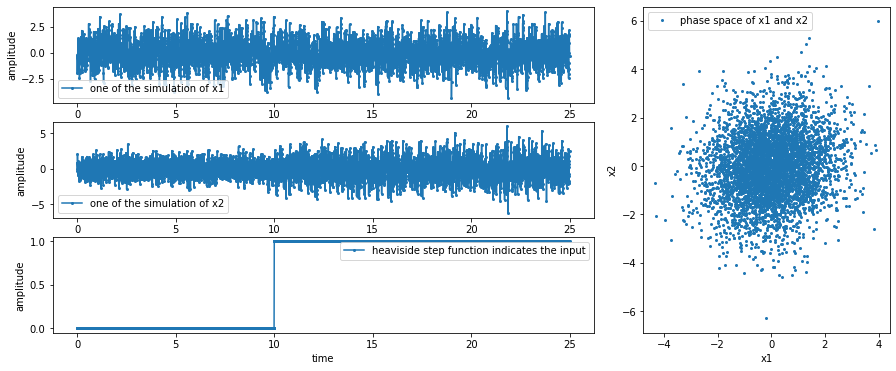

In [12]:
#plotting the figures in a concise manner. 
plt.figure(figsize=(15, 6))
ax1 = plt.subplot(3, 3, (1,2))
ax2 = plt.subplot(3, 3, (4,5))
ax3 = plt.subplot(3, 3, (3,9))
ax4 = plt.subplot(3, 3, (7,8))

ax1.plot(tdata, x1[0], 'o-', ms=2, label='one of the simulation of x1')
ax1.legend(loc='best')
ax1.set_xlabel('time')
ax1.set_ylabel('amplitude')

ax2.plot(tdata, x2[0], 'o-', ms=2, label='one of the simulation of x2')
ax2.legend(loc='best')
ax2.set_xlabel('time')
ax2.set_ylabel('amplitude')

ax3.plot(x1[0], x2[0], 'o', ms=2, label='phase space of x1 and x2')
ax3.legend(loc='best')
ax3.set_xlabel('x1')
ax3.set_ylabel('x2')

ax4.plot(tdata, c, 'o-', ms=2, label='heaviside step function indicates the input')
ax4.legend(loc='best')
ax4.set_xlabel('time')
ax4.set_ylabel('amplitude')

#plt.savefig(f'data-one_sim{sim}_freq{fs}.pdf', dpi=300, bbox_inches='tight')

plt.show()

#plt.savefig(f'data-one_sim{sim}_freq{fs}.pdf', dpi=300, bbox_inches='tight')

# Non-parametric granger causality

In [13]:
series = np.array([x1, x2])
mat_series = np.zeros((len(series), len(series), len(fftfreq(len(tdata), d=(tdata[1]-tdata[0])))))*(1+1j)

#[spectral matrix]#
for i in tqdm(range(mat_series.shape[0])):
    for j in range(mat_series.shape[1]):
        temp_spec, temp_freq = spec(series[i], series[j], tdata)
        mat_series[i,j,:] = temp_spec
        
H, covMat, freq = wilson(mat_series, temp_freq, 50, 1e-10)

100%|██████████| 2/2 [00:03<00:00,  1.96s/it]


In [14]:
#nonparametric granger causality and coherence calculation 
I21 = np.zeros(H.shape[2])*(1+1j) #signal 2 to signal 1
for i in tqdm(range(H.shape[2])):
    Hbar11 = H[0,0,i] + covMat[0,1]/covMat[0,0] * H[0,1,i]
    temp = np.log((mat_series[0,0,i])/(Hbar11 * covMat[0,0] * np.conj(Hbar11)))
    I21[i] = temp
    
I12 = np.zeros(H.shape[2])*(1+1j) #signal 1 to signal 2
for i in tqdm(range(H.shape[2])):
    Hhat22 = H[1,1,i] + (covMat[0,1])/(covMat[1,1]) * H[1,0,i] 
    temp = np.log((mat_series[1,1,i])/(Hhat22 * covMat[1,1] * np.conj(Hhat22)))
    I12[i] = temp
    
I12inst = np.zeros(H.shape[2])*(1+1j) #instantaneous of signal 1 and signal 2
for i in tqdm(range(H.shape[2])):
    Hbar11 = H[0,0,i] + covMat[0,1]/covMat[0,0] * H[0,1,i]
    Hhat22 = H[1,1,i] + (covMat[0,1])/(covMat[1,1]) * H[1,0,i] 
    temp = np.log(((Hbar11*covMat[0,0]*np.conj(Hbar11))*(Hhat22*covMat[1,1]*np.conj(Hhat22)))/(np.linalg.det(mat_series[:,:,i])))
    I12inst[i] = temp
    
Ispect = I21 + I12 + I12inst
cor = 1-np.exp(-Ispect) #coherence

100%|██████████| 5000/5000 [00:00<00:00, 50301.43it/s]


In [15]:
#retain the data for subplot later
freqf = freq
I12f = I12
I21f = I21

In [16]:
######[granger causality] for [time] and [frequency]######
#composing the [spectral matrix]
sample = 256
overlap = 128
f1, t1, z1 = signal.stft(x1, fs, window='hann', nperseg=sample, noverlap=overlap)
f2, t2, z2 = signal.stft(x2, fs, window='hann', nperseg=sample, noverlap=overlap)
conj_z1 = np.conj(z1)
conj_z2 = np.conj(z2)

spec11 = np.mean(z1*conj_z1, axis=0)/(len(tdata))
spec12 = np.mean(z1*conj_z2, axis=0)/(len(tdata))
spec21 = np.mean(z2*conj_z1, axis=0)/(len(tdata))
spec22 = np.mean(z2*conj_z2, axis=0)/(len(tdata))

spec_total = np.array([[spec11, spec12],
                       [spec21, spec22]])

print(signal.check_COLA('hann', sample, overlap, tol=1e-10)) #checking for the suitable windowing for [short-time fourier transform] to ensure the matrix is [positive definite] for later calculation

I21 = np.zeros((spec_total[0,0,0,:].size, spec_total[0,0,:,0].size))*(1+1j)
I12 = np.zeros((spec_total[0,0,0,:].size, spec_total[0,0,:,0].size))*(1+1j)

for t in tqdm(range(spec_total[0,0,0,:].size)):
    H, covMat, freq = wilson(spec_total[:,:,:,t], f1, 40, 1e-15)
    for f in range(freq.size):
        Hbar11 = H[0,0,f] + covMat[0,1]*H[0,1,f]*covMat[0,0]
        temp2 = np.log((spec_total[0,0,f,t])/(Hbar11 * covMat[0,0] * np.conj(Hbar11)))
        I21[t, f] = temp2
        
        Hhat22 = H[1,1,f] + (covMat[0,1])/(covMat[1,1]) * H[1,0,f]
        temp1 = np.log((spec_total[1,1,f,t])/(Hhat22 * covMat[1,1] *np.conj(Hhat22)))
        I12[t, f] = temp1

True


100%|██████████| 41/41 [00:15<00:00,  2.63it/s]


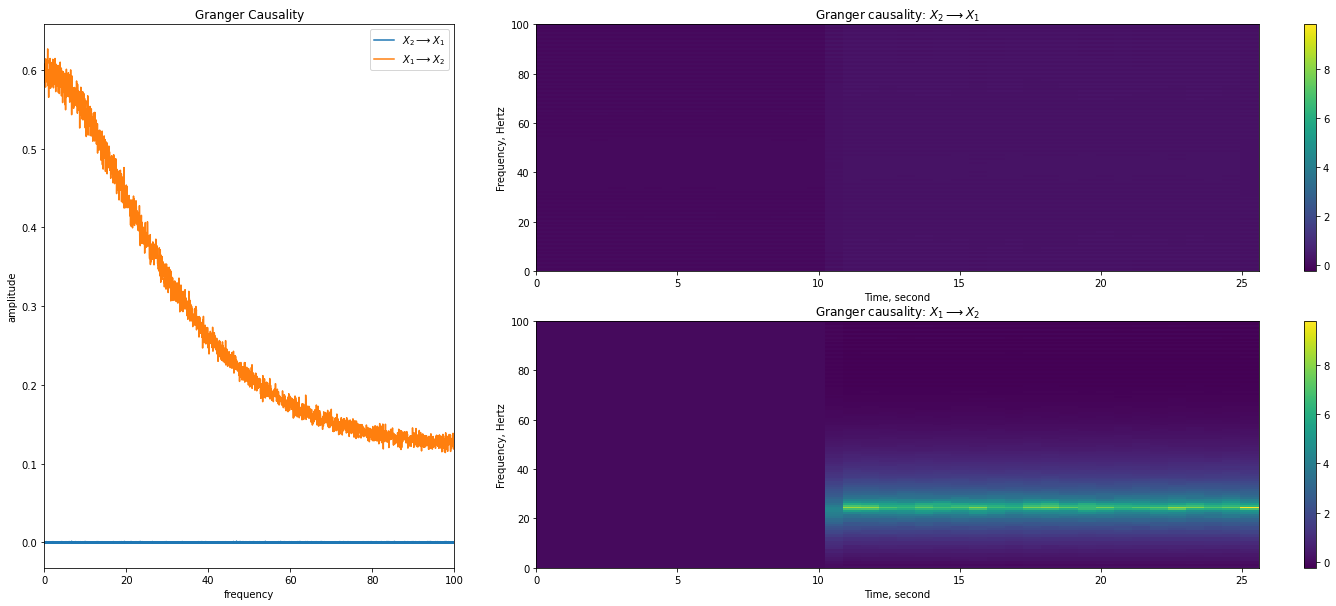

In [17]:
scalemax = np.max(np.maximum(np.real(I12.T), np.real(I21.T)))
scalemin = np.min(np.minimum(np.real(I12.T), np.real(I21.T)))

plt.figure(figsize=(25, 10))
ax1 = plt.subplot(2, 3, (1, 4))
ax2 = plt.subplot(2, 3, (2, 3))
ax3 = plt.subplot(2, 3, (5, 6))

ax1.plot(fftshift(freqf), fftshift(np.real(I21f)), label='$X_2 \longrightarrow X_1$')
ax1.plot(fftshift(freqf), fftshift(np.real(I12f)), label='$X_1 \longrightarrow X_2$')
#ax1.plot(fftshift(freq), fftshift(np.real(I12inst)), label='$X_1 \longleftrightarrow X_2$')
ax1.legend(loc='best')
ax1.set_xlabel('frequency')
ax1.set_ylabel('amplitude')
ax1.set_title('Granger Causality')
ax1.set_xlim(0, np.max(fftshift(freq)))

x21 = ax2.pcolormesh(t2, f2, np.real(I21.T), vmin=scalemin, vmax=scalemax)
ax2.set_xlabel('Time, second')
ax2.set_ylabel('Frequency, Hertz')
ax2.set_title('Granger causality: $X_2 \longrightarrow X_1$')
plt.colorbar(x21, ax=ax2)

x12 = ax3.pcolormesh(t1, f1, np.real(I12.T), vmin=scalemin, vmax=scalemax)
ax3.set_xlabel('Time, second')
ax3.set_ylabel('Frequency, Hertz')
ax3.set_title('Granger causality: $X_1 \longrightarrow X_2$')
plt.colorbar(x12, ax=ax3)

#plt.savefig(f'granger_sim{sim}.pdf', dpi=300, bbox_inches='tight')

plt.show()

#plt.savefig(f'granger_sim{sim}.pdf', dpi=300, bbox_inches='tight')

# Transfer entropy

In [18]:
x1n = x1[:,:]
x2n = x2[:,:]
series = np.array([x1n, x2n])

range_past = 30 
transfer_matrix_series = np.zeros((range_past, len(series), len(series)))
range_t = []

for t in tqdm(range(range_past)):
    past = t
    #size = int(np.ceil(2*(sim*(len(x1n)-past))**(1/3)))
    size = 5
    
    x1n = x1[:,:]
    x2n = x2[:,:]
    series = np.array([x1n, x2n])
    transfer_matrix = np.zeros((len(series), len(series)))
    
    for i in range(len(series)):
        for j in range(len(series)):
            temp_trans1 = all_cal_transfer(series[i], series[j], size, past, sim)
            temp_trans2 = all_cal_transfer(series[j], series[i], size, past, sim)
            transfer_matrix_series[t, i, j] = (temp_trans1 - temp_trans2)
    range_t.append(past)
range_t = np.array(range_t)

  0%|          | 0/30 [00:00<?, ?it/s]<ipython-input-6-cb677a83452f>:115: RuntimeWarning: divide by zero encountered in true_divide
  div = np.einsum('ijk, ijk -> ijk', nume, 1/deno)
<ipython-input-6-cb677a83452f>:117: RuntimeWarning: divide by zero encountered in log2
  temp_log = np.log2(div)
100%|██████████| 30/30 [21:12<00:00, 42.41s/it]


In [19]:
x1n = x1[:,:]
x2n = x2[:,:]

past = 1 #lag number to calculate the transfer entropy. 
win = 100 #window size of the window sliding. 
#size = int(np.ceil(2*(sim*win)**(1/3))) #bin size in estimating the PDF for [transfer entropy] calculation; rice's rule on determining the bin size. 
size = 5

data_list = {}
series = np.array([x1n, x2n])

for i in tqdm(range(len(series))):
    for j in range(len(series)):
        entro_list = []
        time_list = []
        for t in range(0, len(tdata), 100): #NOTE: the jump of [100] time step is to make the calculation quick; ideally would be good to be [1]. 
            temp_x1n = x1n[:,t:t+win]
            temp_x2n = x2n[:,t:t+win]
            
            series = np.array([temp_x1n, temp_x2n])
            
            temp_trans = all_cal_transfer(series[i], series[j], size, past, sim)
            #print(x1n)
            entro_list.append(temp_trans)
            time_list.append(tdata[t])
            #print(i, j, t/len(tdata), end='\r')
        entro_list = np.array(entro_list)
        data_list.update({f'{i+1} to {j+1}': entro_list})

  0%|          | 0/2 [00:00<?, ?it/s]<ipython-input-6-cb677a83452f>:115: RuntimeWarning: divide by zero encountered in true_divide
  div = np.einsum('ijk, ijk -> ijk', nume, 1/deno)
<ipython-input-6-cb677a83452f>:117: RuntimeWarning: divide by zero encountered in log2
  temp_log = np.log2(div)
100%|██████████| 2/2 [00:29<00:00, 14.54s/it]


100%|██████████| 2/2 [00:00<00:00, 102.82it/s]


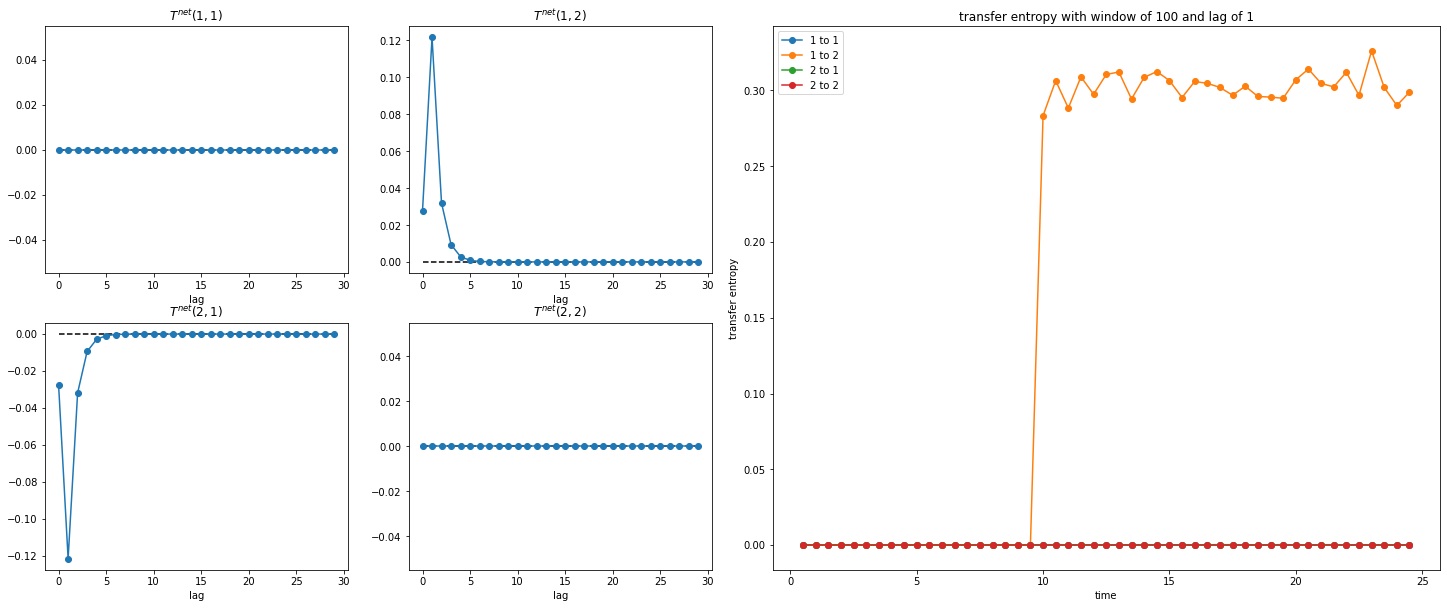

In [20]:
plt.figure(figsize=(25, 10))
ax1 = plt.subplot(2, 4, 1)
ax2 = plt.subplot(2, 4, 2)
ax3 = plt.subplot(2, 4, 5)
ax4 = plt.subplot(2, 4, 6)
plot_series = np.array([[ax1, ax2], [ax3, ax4]])
ax5 = plt.subplot(2, 4, (3, 8))

for i in tqdm(range(len(series))):
    for j in range(len(series)):
        plot_series[i,j].plot(range_t, transfer_matrix_series[:,i,j], 'o-')
        plot_series[i,j].hlines(0, 0, np.max(range_t), linestyles='dashed')
        #plot_series[i,j].set_xlabel(r'$\alpha, \beta$')
        plot_series[i,j].set_xlabel('lag')
        title = i+1, j+1
        plot_series[i,j].set_title('$T^{net}$' + f'${title}$')
        ax5.plot(np.delete(time_list, 0), np.delete(data_list[f'{i+1} to {j+1}'], 0), 'o-', label=f'{i+1} to {j+1}')
plt.legend(loc='best')
plt.xlabel('time')
plt.ylabel('transfer entropy')
plt.title(f'transfer entropy with window of {win} and lag of {past}')

#plt.savefig(f'transfer_sim{sim}_win{win}.pdf', dpi=300, bbox_inches='tight')

plt.show()

#plt.savefig(f'transfer_sim{sim}_win{win}.pdf', dpi=300, bbox_inches='tight')

# Information rate & information length

In [ ]:
#estimate the evolution of the [pdf] at different instance via histogram
win = 50
sld = 1
datapdf, datatime = pdf_evol(x1, x2, tdata, win, sld, sim)

In [ ]:
plt.figure(figsize=(15,6))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)
for i in range(len(datatime)):
    ax1.plot(datapdf['pdf_1'][1][i,0,1:], datapdf['pdf_1'][0][i,:], 'o-', ms=2, label='pdf_x1')
    ax2.plot(datapdf['pdf_2'][1][i,0,1:], datapdf['pdf_2'][0][i,:], 'o-', ms=2, label='pdf_x2')
ax1.set_xlabel('x1')
ax1.set_ylabel('pdf_x1')
handles1, labels1 = ax1.get_legend_handles_labels()
display = [0]
ax1.legend([handle for i,handle in enumerate(handles1) if i in display], 
          [label for i,label in enumerate(labels1) if i in display], loc='best')

ax2.set_xlabel('x2')
ax2.set_ylabel('pdf_x2')
handles2, labels2 = ax2.get_legend_handles_labels()
display = [0]
ax2.legend([handle for i,handle in enumerate(handles2) if i in display], 
          [label for i,label in enumerate(labels2) if i in display], loc='best')
plt.show()

In [ ]:
#3D plot of x1's [pdf] evolution
fig1 = go.Figure(data=[go.Surface(x=datapdf['pdf_1'][1][:,0,:], y=datatime, z=datapdf['pdf_1'][0][:,:], 
                                  showscale=False, opacity=0.3)])
fig1.update_layout(title='pdf evolution of x1', titlefont=dict(size=20), autosize=False, 
                   scene=dict(xaxis_title='amplitude', yaxis_title='time', zaxis_title='pdf_x1'), 
                   width=1_000, height=900, margin=dict(r=20, b=10, l=10, t=50), 
                   scene_camera_eye=dict(x=-0.5, y=2.0, z=-0.35))
fig1.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor='limegreen', project_z=True))
fig1.show()

In [ ]:
#3D plot of x2's [pdf] evolution
fig2 = go.Figure(data=[go.Surface(x=datapdf['pdf_2'][1][:,0,:], y=datatime, z=datapdf['pdf_2'][0][:,:], 
                                  showscale=False, opacity=0.3)])
fig2.update_layout(title='pdf evolution of x2', titlefont=dict(size=20), autosize=False, 
                   scene=dict(xaxis_title='amplitude', yaxis_title='time', zaxis_title='pdf_x2'), 
                   width=1_000, height=900, margin=dict(r=20, b=10, l=10, t=50), 
                   scene_camera_eye=dict(x=-0.5, y=2.0, z=-0.35))
fig2.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor='limegreen', project_z=True))
fig2.show()

In [ ]:
#calculate information rate for marginal pdf
rate1, time1 = info_rate(datapdf['pdf_1'][0], datapdf['pdf_1'][1], datatime)
rate2, time2 = info_rate(datapdf['pdf_2'][0], datapdf['pdf_1'][1], datatime)

#calculate information length for marginal pdf
len1 = np.cumsum(np.sqrt(rate1) * (time1[1]-time1[0]))
len2 = np.cumsum(np.sqrt(rate2) * (time2[1]-time2[0]))

In [ ]:
plt.figure(figsize=(15, 6))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.plot(time1, rate1, 'o-', label='$\Gamma^2$ of x1', ms=2)
ax1.plot(time2, rate2, 'o-', label='$\Gamma^2$ of x2', ms=2)
ax1.legend(loc='best')
ax1.set_xlabel('time')
ax1.set_ylabel('information rate square, $\Gamma^2$')

ax2.plot(time1, len1, 'o-', label='$\mathcal{L}$ of x1', ms=2)
ax2.plot(time2, len2, 'o-', label='$\mathcal{L}$ of x2', ms=2)
ax2.legend(loc='best')
ax2.set_xlabel('time')
ax2.set_ylabel('information length, $\mathcal{L}$')

plt.savefig(f'info-margi_sim{sim}_win{win}_sld{sld}.pdf', dpi=300, bbox_inches='tight')

plt.show()

#plt.savefig(f'info-margi_sim{sim}_win{win}_sld{sld}.pdf', dpi=300, bbox_inches='tight')

In [ ]:
#[joint pdf]
plt.figure()
for i in range(len(datatime)):
    plt.contour(datapdf['pdf_joint'][1][i][0][1:], datapdf['pdf_joint'][1][i][1][1:], datapdf['pdf_joint'][0][i])
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(title='p(x1,x2)', loc='best')
plt.colorbar()
plt.show()

plt.figure()
for i in range(len(datatime)):
    plt.contour(datapdf['pdf_mul'][1][i][0][1:], datapdf['pdf_mul'][1][i][1][1:], datapdf['pdf_mul'][0][i])
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend(title='p(x1)p(x2)', loc='best')
plt.colorbar()
plt.show()

In [ ]:
plt.figure(figsize=(15, 6))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

t_list = [0, 43]
for t in t_list:
    ax1.contour(datapdf['pdf_joint'][1][t][0][1:], datapdf['pdf_joint'][1][t][1][1:], datapdf['pdf_joint'][0][t])
    ax2.contour(datapdf['pdf_mul'][1][t][0][1:], datapdf['pdf_mul'][1][t][1][1:], datapdf['pdf_mul'][0][t])
    
ax1.set_xlabel('x1')
ax1.set_ylabel('x2')
ax1.legend(title='joint pdf, p(x1,x2)', loc='best')
ax1.set_title(f'pdf at time {datatime[t_list[0]]} and time {datatime[t_list[1]]}')

ax2.set_xlabel('x1')
ax2.set_ylabel('x2')
ax2.legend(title='mul pdf, p(x1)p(x2)', loc='best')
ax2.set_title(f'pdf at time {datatime[t_list[0]]} and time {datatime[t_list[1]]}')

plt.show()

In [ ]:
t1 = 0
figm1 = go.Figure(data=[go.Surface(x=datapdf['pdf_mul'][1][t1,0,:], y=datapdf['pdf_mul'][1][t1,1,:], 
                                  z=datapdf['pdf_mul'][0][t1,:,:], 
                                  showscale=False, opacity=0.3)])
figm1.update_layout(title=f'joint pdf of x1 & x2 at time {datatime[t1]}', titlefont=dict(size=20), autosize=False, 
                   scene=dict(xaxis_title='x1', yaxis_title='x2', zaxis_title='pdf_p(x1)p(x2)'), 
                   width=1_000, height=900, margin=dict(r=20, b=10, l=10, t=50), 
                   scene_camera_eye=dict(x=-0.5, y=2.0, z=-0.35))
figm1.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor='limegreen', project_z=True))
figm1.show()

t2 = 43
figm2 = go.Figure(data=[go.Surface(x=datapdf['pdf_mul'][1][t2,0,:], y=datapdf['pdf_mul'][1][t2,1,:], 
                                  z=datapdf['pdf_mul'][0][t2,:,:], 
                                  showscale=False, opacity=0.3)])
figm2.update_layout(title=f'joint pdf of x1 & x2 at time {datatime[t2]}', titlefont=dict(size=20), autosize=False, 
                   scene=dict(xaxis_title='x1', yaxis_title='x2', zaxis_title='pdf_p(x1)p(x2)'), 
                   width=1_000, height=900, margin=dict(r=20, b=10, l=10, t=50), 
                   scene_camera_eye=dict(x=-0.5, y=2.0, z=-0.35))
figm2.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor='limegreen', project_z=True))
figm2.show()

t3 = 86
figm3 = go.Figure(data=[go.Surface(x=datapdf['pdf_mul'][1][t3,0,:], y=datapdf['pdf_mul'][1][t3,1,:], 
                                  z=datapdf['pdf_mul'][0][t3,:,:], 
                                  showscale=False, opacity=0.3)])
figm3.update_layout(title=f'joint pdf of x1 & x2 at time {datatime[t3]}', titlefont=dict(size=20), autosize=False, 
                   scene=dict(xaxis_title='x1', yaxis_title='x2', zaxis_title='pdf_p(x1)p(x2)'), 
                   width=1_000, height=900, margin=dict(r=20, b=10, l=10, t=50), 
                   scene_camera_eye=dict(x=-0.5, y=2.0, z=-0.35))
figm3.update_traces(contours_z=dict(show=True, usecolormap=True, highlightcolor='limegreen', project_z=True))
figm3.show()

In [ ]:
#calculate information rate for 2D pdf
ratejoint, timejoint = info_rate2D(datapdf['pdf_joint'][0], datapdf['pdf_joint'][1], datatime)
ratemul, timemul = info_rate2D(datapdf['pdf_mul'][0], datapdf['pdf_mul'][1], datatime)

#calculate information length for 2D pdf 
lenjoint = np.cumsum(np.sqrt(ratejoint) * (timejoint[1]-timejoint[0]))
lenmul = np.cumsum(np.sqrt(ratemul) * (timemul[1]-timemul[0]))

In [ ]:
plt.figure(figsize=(15, 6))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.plot(timejoint, ratejoint, 'o-', label='$\Gamma^2$ of x1 & x2', ms=2)
ax1.plot(timemul, ratemul, 'o-', label='$\Gamma^2$ of x1 $\cdot$ x2', ms=2)
ax1.legend(loc='best')
ax1.set_xlabel('time')
ax1.set_ylabel('information rate square, $\Gamma^2$')

ax2.plot(timejoint, lenjoint, 'o-', label='$\mathcal{L}$ of x1 & x2', ms=2)
ax2.plot(timemul, lenmul, 'o-', label='$\mathcal{L}$ of x1 $\cdot$ x2', ms=2)
ax2.legend(loc='best')
ax2.set_xlabel('time')
ax2.set_ylabel('information length, $\mathcal{L}$')

plt.savefig(f'info-joint_sim{sim}_win{win}_sld{sld}.pdf', dpi=300, bbox_inches='tight')

plt.show()

#plt.savefig(f'info-joint_sim{sim}_win{win}_sld{sld}.pdf', dpi=300, bbox_inches='tight')

In [ ]:
#calculate the [information rate causality]#
win = 100
dataratecausal, datatimecausal = info_rate_causal(x1, x2, tdata, win, sim)

In [ ]:
cor_ratecausal1to2 = np.concatenate(dataratecausal['rate_1to2'])
cor_ratecausal2to1 = np.concatenate(dataratecausal['rate_2to1'])
cor_rate1 = np.concatenate(dataratecausal['rate_1'])
cor_rate2 = np.concatenate(dataratecausal['rate_2'])
cor_timecausal = np.concatenate(datatimecausal)

In [ ]:
lencausal1to2 = np.cumsum(np.sqrt(cor_ratecausal1to2) * (cor_timecausal[1] - cor_timecausal[0]))
lencausal2to1 = np.cumsum(np.sqrt(cor_ratecausal2to1) * (cor_timecausal[1] - cor_timecausal[0]))
lencausal1 = np.cumsum(np.sqrt(cor_rate1) * (cor_timecausal[1] - cor_timecausal[0]))
lencausal2 = np.cumsum(np.sqrt(cor_rate2) * (cor_timecausal[1] - cor_timecausal[0]))

In [ ]:
plt.figure(figsize=(15, 6))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.plot(cor_timecausal, cor_ratecausal1to2, 'o-', ms=2, label='$\Gamma^2$ of x1 to x2')
ax1.plot(cor_timecausal, cor_ratecausal2to1, 'o-', ms=2, label='$\Gamma^2$ of x2 to x1')
ax1.plot(cor_timecausal, cor_rate1, 'o-', ms=2, label='$\Gamma^2$ of x1')
ax1.plot(cor_timecausal, cor_rate2, 'o-', ms=2, label='$\Gamma^2$ of x2')
ax1.legend(loc='best')
ax1.set_xlabel('time')
ax1.set_ylabel('information rate square, $\Gamma^2$')
ax1.set_yscale('log')

ax2.plot(cor_timecausal, lencausal1to2, 'o-', ms=2, label='$\mathcal{L}$ of x1 to x2')
ax2.plot(cor_timecausal, lencausal2to1, 'o-', ms=2, label='$\mathcal{L}$ of x2 to x1')
ax2.plot(cor_timecausal, lencausal1, 'o-', ms=2, label='$\mathcal{L}$ of x1')
ax2.plot(cor_timecausal, lencausal2, 'o-', ms=2, label='$\mathcal{L}$ of x2')
ax2.legend(loc='best')
ax2.set_xlabel('time')
ax2.set_ylabel('information length, $\mathcal{L}$')

plt.savefig(f'causal-info-joint_sim{sim}_win{win}_sld{sld}.pdf', dpi=300, bbox_inches='tight')

plt.show()

#plt.savefig(f'causal-info-joint_sim{sim}_win{win}_sld{sld}.pdf', dpi=300, bbox_inches='tight')

In [ ]:
plt.figure(figsize=(15, 6))
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

ax1.plot(cor_timecausal, cor_ratecausal1to2, 'o-', ms=2, label='$\Gamma^2$ of x1 to x2')
ax1.plot(cor_timecausal, cor_ratecausal2to1, 'o-', ms=2, label='$\Gamma^2$ of x2 to x1')
ax1.plot(cor_timecausal, cor_rate1, 'o-', ms=2, label='$\Gamma^2$ of x1')
ax1.plot(cor_timecausal, cor_rate2, 'o-', ms=2, label='$\Gamma^2$ of x2')
ax1.legend(loc='best')
ax1.set_xlabel('time')
ax1.set_ylabel('information rate square, $\Gamma^2$')
#ax1.set_yscale('log')

ax2.plot(cor_timecausal, lencausal1to2, 'o-', ms=2, label='$\mathcal{L}$ of x1 to x2')
ax2.plot(cor_timecausal, lencausal2to1, 'o-', ms=2, label='$\mathcal{L}$ of x2 to x1')
ax2.plot(cor_timecausal, lencausal1, 'o-', ms=2, label='$\mathcal{L}$ of x1')
ax2.plot(cor_timecausal, lencausal2, 'o-', ms=2, label='$\mathcal{L}$ of x2')
ax2.legend(loc='best')
ax2.set_xlabel('time')
ax2.set_ylabel('information length, $\mathcal{L}$')

plt.savefig(f'causal1-info-joint_sim{sim}_win{win}_sld{sld}.pdf', dpi=300, bbox_inches='tight')

plt.show()

#plt.savefig(f'causal1-info-joint_sim{sim}_win{win}_sld{sld}.pdf', dpi=300, bbox_inches='tight')